In [1]:
# этот скрипт отрисосывает свечи в реальном времени по истории последних сделок. был необходим по причине того, что на 
# биттрексе свечки отрисовывались с задержкой около 4 минут, что недопустимо много в условиях высокой волатильности 
# во время firepump`a, в которые я так любил впрыгивать(к слову, небезуспешно). 

In [ ]:
from bittrex import Bittrex
bittrex = Bittrex(None, None)
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick_ochl
import numpy as np

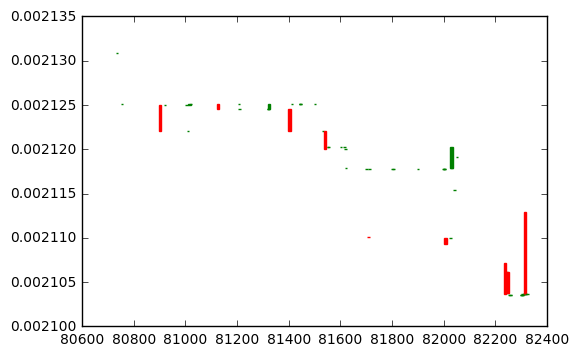

In [35]:
h = bittrex.get_market_history('BTC-ETC', 20)   # получить историю сделок по монете

ts = []                              # составить список меток времени последних сделок
for i in h.get('result'):
    ts.append(i.get('TimeStamp'))
    
a = []
for i in h.get('result'):
    b = {}
    b[i.get('TimeStamp')[11:19]] = i # получить время в формате "час\минута\секунда"
    a.append(b)

cand = {}                # составляем словарь вида {время: цена, id, тип сделки, суммарный объем}
for i in a:
    val = i.popitem()
    key = val[0]
    values = val[1].get('Price'), val[1].get('Id'), val[1].get('OrderType'), val[1].get('Total')
    key = key.replace(':', '')
    if key in cand.keys():
        cand[key] += tuple(values)
    else:
        cand[key] = values
        
cand2 = {}
var = cand.keys()
#print (var)
for k in var:
    q = np.array([])
    a = np.array([])
    for e, i in enumerate(cand.get(k)):    # e - позиция отдельной записи в словаре, е == 0 - цена, е == 1 id. 
        if e % 4 == 1:
            q = np.append(q, cand.get(k)[e]) # id для выбора цены открытия и закрытия
        if e % 4 == 0:
            a = np.append(a, cand.get(k)[e]) # значения цены для определения макс и мин
    cand2[k] = (a), (q)    # cand2 - словарь вида {время: цена, id}
    
    
# составляем окончательный словарь по принципу: взять значение времени с точностью до минуты, найти максимальный и минимальный
# id для этого времени, взять цену этих сделок, получится цена открытия и закрытия;
# для определения максимальной и минимальной цены в отрезке времени ищем max или min за этот отрезок


var = cand2.keys()
price = []
for v in var:
    h_price = cand2.get(v)[0].max() # 
    l_price = cand2.get(v)[0].min() # высшая и низшая цена за период
    
    c_id = cand2.get(v)[1].max() # определение ид закрытия
    o_id = cand2.get(v)[1].min() # определение ид открытия
    
    c_index = np.where(cand2.get(v)[1] == c_id) # индекс ид закрытия
    o_index = np.where(cand2.get(v)[1] == o_id) # индекс ид открытия
    
    c_index = c_index[0][0]
    o_index = o_index[0][0]
    
    c_price = cand2.get(v)[0][c_index] # 
    o_price = cand2.get(v)[0][o_index] # цена закрытия и открытия
    
    data = int(v), o_price, c_price, h_price, l_price
    price.append(data)
    # полученный список имеет вид [время(в целых числах, например 18:50:00 будет 185000), цена открытия, цена закрытия, высшая и низшая цена]
    
fig, ax = plt.subplots()
candlestick_ochl(ax, quotes=price, colorup='g', width=10)
plt.show()